# 自适应滤波器 Adaptive Filtering

    

    自适应滤波器想法很简单，就是在变化的时候，系统能够检查到变化，并能够紧跟着变化自己的参数从而适应这种变化。

    具体的来思考，一般情况下我们在使用线性卡尔曼滤波器的时候，我们会发现当我们采用的阶次越高的时候，系统所能够描述的信息更大，因此更加能够收敛到准确解。但是，线性卡尔曼滤波器对于突变、对于非线性控制变化不够敏感，经常需要等到变化稳定下来一段时间才能够再次收敛到准确解。究其原因，是因为线性卡尔曼滤波器对位置、过程不确定性都设置为一常量，这常量适合于线性稳定的运行阶段，但是到了变化阶段，较小的不确定性，让系统固执的相信自己的预估值，而忽视测量值的作用，从而使得滤波器偏离了准确值。
    
    因此，这个时候我们可以想到状态预估计不确定性$\bar P = FPF^T + Q$，只要我们将状态不确定性系数在变化时调大一些，让系统更加相信测量值，随后系统稳定了，再调回去。
    
    于是，我们就有方法：Q增益法；P增益法。  
    这两个方法本质上是一致的，只是增益的对象不同罢了，但是，P增益法由于是增益在了P上，使得当前状态的不确定性系数很难再和之前较远时的状态关联起来，因此，时常会看到，在这种方法滤波下，滤波器经历了变化后渐于稳定的时候却会有小幅的波动，因此也把这种方法称作"Fading Memory Filter"。

## MMAE

然而，无论这上述两个方法中那个方法，都会对测量的准确性较为依赖，如果测量不准确，变会产生较大偏离，因此，在使用时，我们通常还要对其再进行优化，从而有了MMAE(Mutiple Mode Adaptive Estimation)方法，其作用在于，采用多个不同的线性卡尔曼滤波器进行耦合，按照一定的、具有修正能力的权重来配比输出最终滤波值。

因此，其算法可以写作： $x =\sum_{i=1}^N x_i\bar P_i$ 

其中：$$\bar P_i = P_k^i = \frac{L_k^i P_{k-1}^i}{\sum_{j=1}^N L_k^j P_{k-1}^j}$$
$$ L = \frac{1}{\sqrt {2\pi s}}exp(-\frac{1}{2}y^TS^{-1}y)$$

## IMME

紧接着，我么有会发现MMAE方法随着多种滤波器假设的增多将导致组合爆炸，这不利于计算。

因此，我们又引入了IMME（Interating Multiple Modes）方法，起作用在于，揪出其中某一个行为特征设置两三个线性卡尔曼滤波器，这样在对于这一单一的行为特征的描述过程中，这些滤波器可以相互制约、相互作用，选择其中一个合适的比例来采用。

在真正的使用过程中，我们会对这一行为再依据过程分为两面、三面…等，进而建立相对应于每一面的线性卡尔曼滤波器两个、三个…，再进行混合。

算法如下：

1. 在有测量为z后，行为状态为第i面的概率为$\mu _i = P(m_i\mid z)$，组合为数组$ \mu = [\mu _1,\mu _2,…]$
2. 行为状态为第i面时，也可能有误判可能，因此给出一个概率转换矩阵$M = \left\lgroup \matrix{p & 1-p \cr 1-q & q} \right\rgroup$
3. 从而有了全概率$\bar C_j = \sum_i \mu_iM_{ij}$
4. 计算混合概率系数为：$w_{ij} = \frac{\mu_iM_{ij}}{\bar C_j}$
5. 由混合系数确定混合条件：
$$ X_i^m = \sum_iw_{ij}X_i$$
$$ P_j^m = \sum_iw_{ij}[(x^i- x_i^m)(x^i- x_i^m)^T + P_i]$$
6. 再得先验假设估计：
$$ \bar X_j = F_jX_j^m$$
$$ \bar P_j = F_jP_j^mF_j^T + Q_j$$
7. 最后得估计值：
$$ x = \sum_j \mu_j \bar X_j$$
$$ P = \sum_j \mu_j [(\bar X_j - \bar X)(\bar X_j - \bar X)^T + \bar P_j]$$

## 例题
接下来看一个例题，消化一下

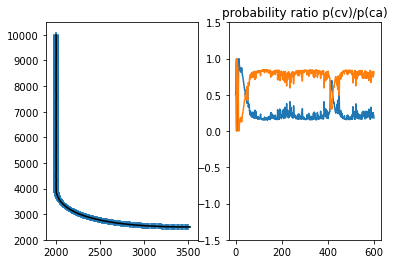

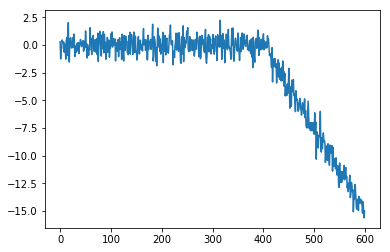

In [11]:
% matplotlib inline
import copy
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
from filterpy.kalman import IMMEstimator,KalmanFilter
from scipy.linalg import block_diag
import kf_book.adaptive_internal as adaptive_internal

N = 600
dt = 1.
track = adaptive_internal.turning_target(N)  # 生成了一个前400个点为无加速运动点，而后有加速度运动点，其中track[:,0]&track[:1]为第一个滤波器

dt2 = (dt**2)/2
F = np.array([[1, dt, dt2],
              [0,  1,  dt],
              [0,  0,   1]])
q = np.array([[.05, .125, 1/6],
              [.125, 1/3, .5],
              [1/6, .5, 1]])*1.e-3

# create noisy measurements
zs = np.zeros((N, 2))
r = 1
for i in range(N):
    zs[i, 0] = track[i, 0] + randn()*r
    zs[i, 1] = track[i, 2] + randn()*r

ca = KalmanFilter(dim_x=6, dim_z=2)      
ca.F = block_diag(F, F)
ca.x = np.array([[2000., 0, 0, 10000, -15, 0]]).T
ca.P *= 1.e-12
ca.R *= r**2
ca.Q = block_diag(q, q)
ca.H = np.array([[1, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0]])

# create identical filter, but with no process error
cano = copy.deepcopy(ca)    # 区别于copy.copy()，deepcopy是深层拷贝，即将拷贝对象内容完全拷贝，而当拷贝后的像发生无论深层还是浅层改变时，原像皆不变
cano.Q *= 0

filters = [ca, cano]      # 由常速滤波cano与常加速滤波ca混合，生成混合滤波器

mu = np.array([0.5, 0.5])
M = np.array([[0.97, 0.03],
              [0.03, 0.97]])        # 描述，在测量后的情况下，行为分别为mode i的概率为mu；其行为描述准确性为M

bank = IMMEstimator(filters, mu, M) # 由混合滤波器，生成交互多模估计器bank

xs, probs = [], []
cvxs, caxs = [], []
for i, z in enumerate(zs):
    z = np.array([z]).T
    bank.update(z)

    xs.append(bank.x.copy())   # bank.x 生成滤波状态值
    cvxs.append(ca.x.copy())
    caxs.append(cano.x.copy())
    probs.append(bank.mu.copy())# bank.mu生成权值系数变换的描述，展现出那个filter占据了主导作用

xs = np.array(xs)
cvxs = np.array(cvxs)
caxs = np.array(caxs)
probs = np.array(probs)

plt.subplot(121)
plt.plot(xs[:, 0], xs[:, 3], 'k')
plt.scatter(zs[:, 0], zs[:, 1], marker='+')

plt.subplot(122)
plt.plot(probs[:, 0])
plt.plot(probs[:, 1])
plt.ylim(-1.5, 1.5)
plt.title('probability ratio p(cv)/p(ca)');

plt.figure()
plt.plot(range(N),zs[:,0]-xs[:,0,0])